In [79]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

data = pd.read_csv('Houses.csv', encoding='latin-1')

In [80]:
data.head()

,Unnamed: 0,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,0,Podgórze Zab³ocie Stanis³awa Klimeckiego,Kraków,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,1,Praga-Po³udnie Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,2,Krowodrza Czarnowiejska,Kraków,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0
3,3,Grunwald,Poznañ,2.0,4315.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0
4,4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0


In [81]:
data.dtypes

Unnamed: 0      int64
address        object
city           object
floor         float64
id            float64
latitude      float64
longitude     float64
price         float64
rooms         float64
sq            float64
year          float64
dtype: object

In [82]:
data.duplicated().sum()


0

In [83]:
data.isna().sum()

Unnamed: 0    0
address       0
city          0
floor         0
id            0
latitude      0
longitude     0
price         0
rooms         0
sq            0
year          0
dtype: int64


#### Cleaning the data

In [84]:
ndc = data.copy(deep=True)
ndc = ndc.drop(columns=['Unnamed: 0','address','id'])
ndc['city'] = ndc['city'].replace(['Poznañ'], 'Poznań')

We also want to add column with price per square meter and square meters per room.

In [85]:
price_per_sq = ndc['price'] / ndc['sq']
ndc['price per sq'] = price_per_sq

sq_per_room = ndc['sq'] / ndc['rooms']
ndc['sq per room'] = sq_per_room

Let's check outliers in our dataset.

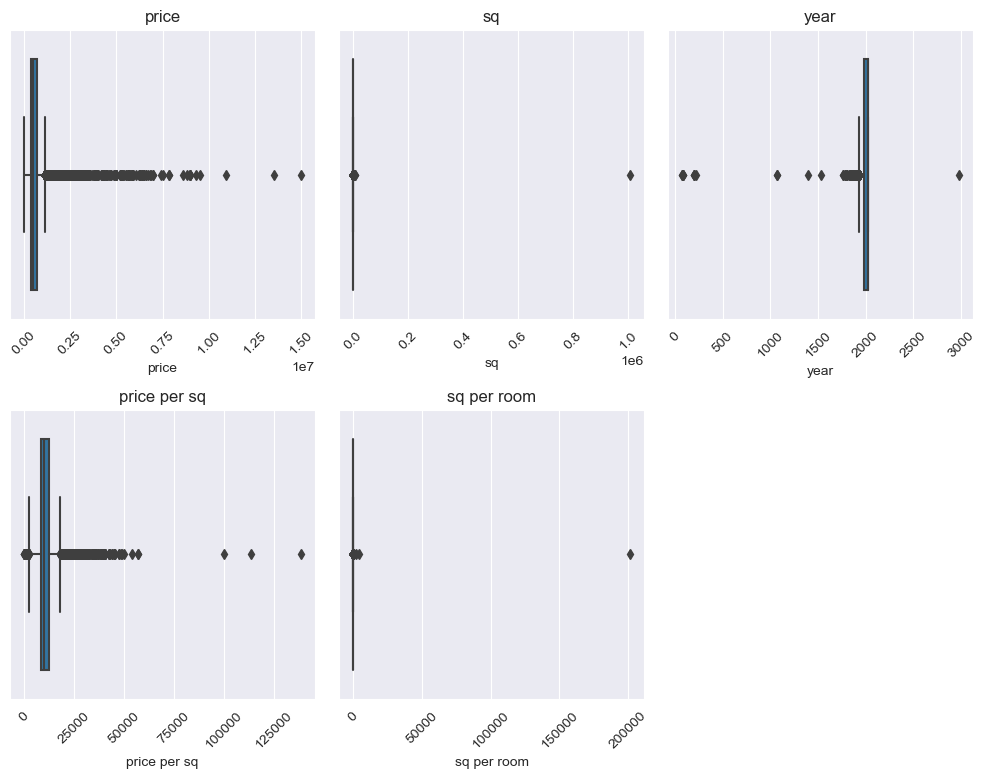

In [86]:
cols = tuple(ndc.columns)
cols_data=(cols[4], cols[6], cols[7], cols[8], cols[9])

labels= ['price', 'sq', 'year', 'price per sq', 'sq per room']

plt.figure(figsize=(10,30))
for i in range(len(cols_data)):
    plt.subplot(8,3,i+1)
    plt.title(labels[i])
    plt.xticks(rotation=45)
    sns.boxplot(ndc[cols_data[i]])

plt.tight_layout()

As we can see, we have huge amount of outliers, we use z-score to handle them.

In [87]:
cols = ['price', 'sq', 'year', 'price per sq', 'sq per room']

z_thresh = 2.7

ndc = ndc[(np.abs(stats.zscore(ndc[cols])) < z_thresh).all(axis=1)]

Now, we can divide the data into 3 cities and perform EDA.

In [88]:
ndc_waw = ndc[ndc["city"].isin(['Warszawa'])]
ndc_kra = ndc[ndc["city"].isin(['Kraków'])]
ndc_poz = ndc[ndc["city"].isin(['Poznań'])]

#### distribution plots for price and price per square meter

##### All 3 cities

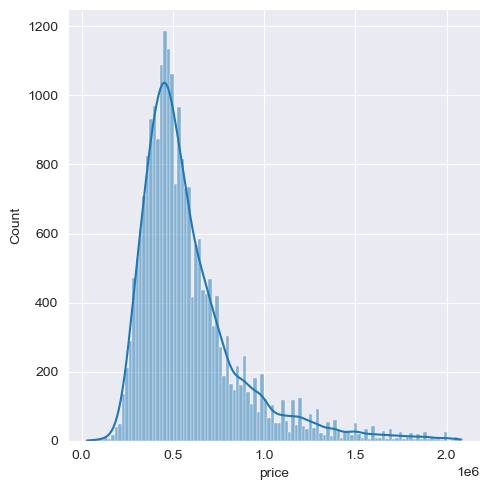

In [89]:
sns.displot(data=ndc['price'], kde=True)

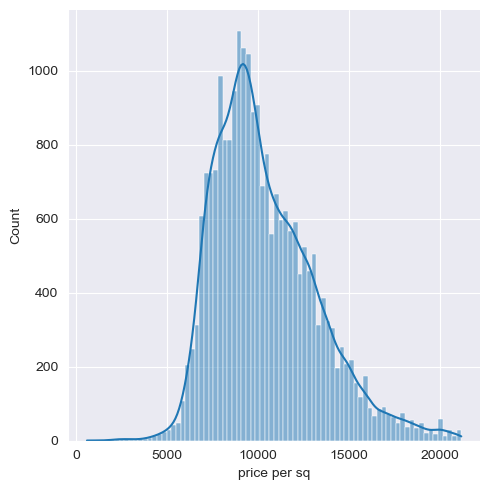

In [90]:
sns.displot(data=ndc['price per sq'], kde=True)

##### Krakow

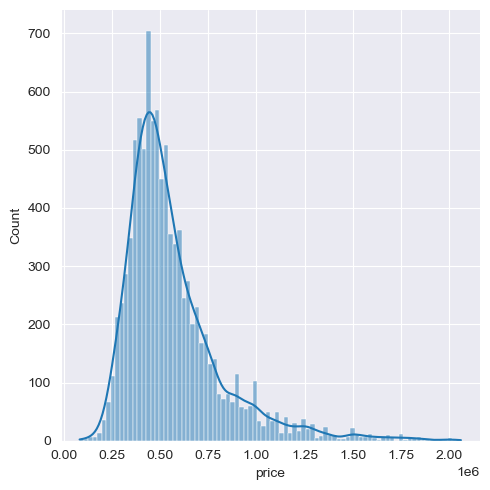

In [91]:
sns.displot(data=ndc_kra['price'], kde=True)

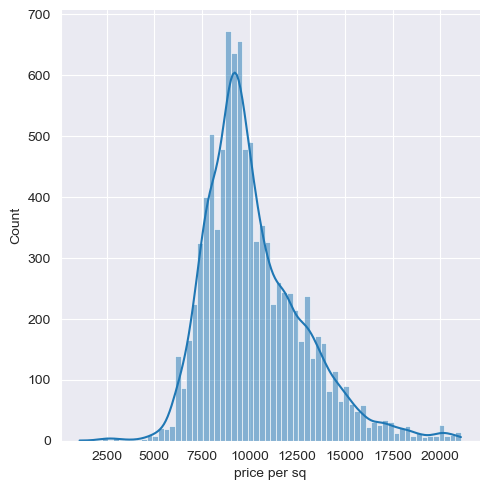

In [92]:
sns.displot(data=ndc_kra['price per sq'], kde=True)

##### Poznan

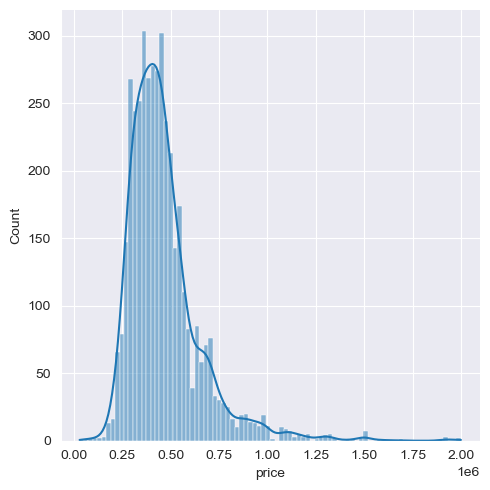

In [93]:
sns.displot(data=ndc_poz['price'], kde=True)

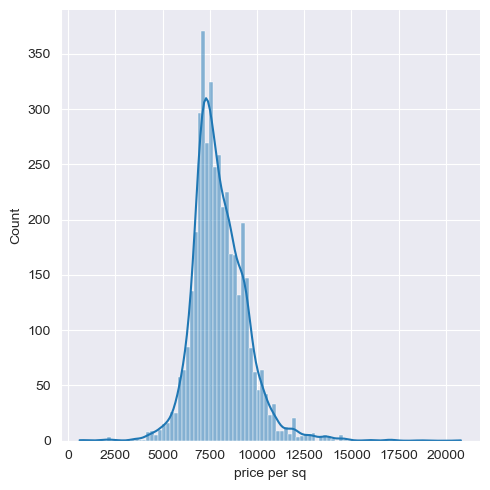

In [94]:
sns.displot(data=ndc_poz['price per sq'], kde=True)

##### Warszawa

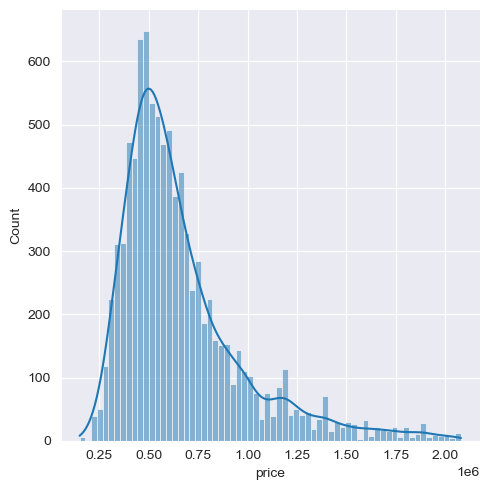

In [95]:
sns.displot(data=ndc_waw['price'], kde=True)

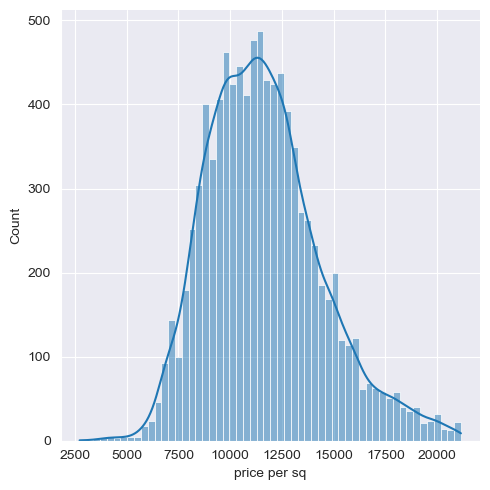

In [96]:
sns.displot(data=ndc_waw['price per sq'], kde=True)

#### Sale price vs year built

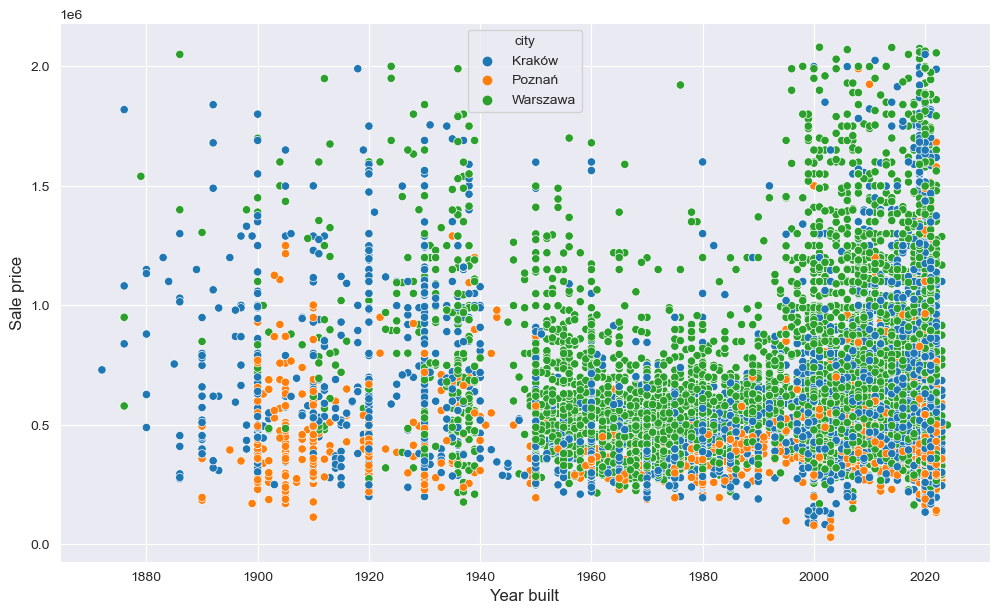

In [97]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='year', y='price', data=ndc, hue='city', hue_order = ['Kraków', 'Poznań', 'Warszawa'])
plt.xlabel('Year built', fontsize = 12)
plt.ylabel('Sale price', fontsize = 12)
plt.show()

#### Sale price vs sq

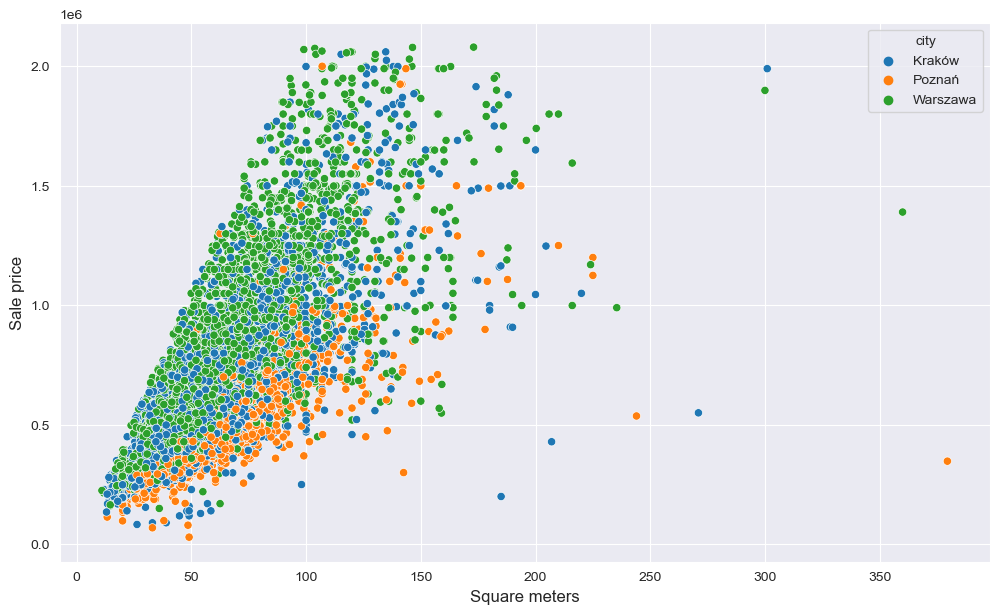

In [98]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='sq', y='price', data=ndc, hue='city', hue_order = ['Kraków', 'Poznań', 'Warszawa'])
plt.xlabel('Square meters', fontsize = 12)
plt.ylabel('Sale price', fontsize = 12)
plt.show()

### City histogram

<AxesSubplot:xlabel='city', ylabel='Count'>

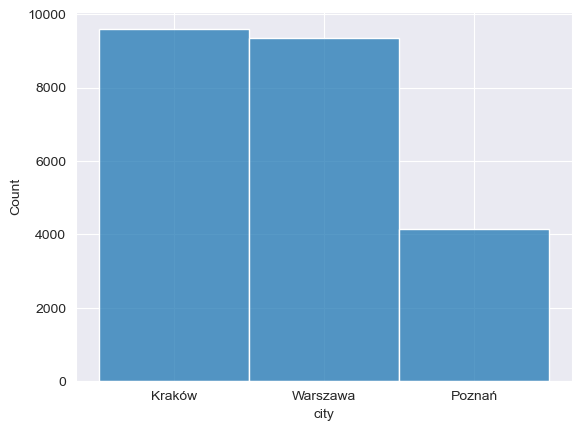

In [99]:
sns.histplot(data=ndc['city'])

#### Heatmap

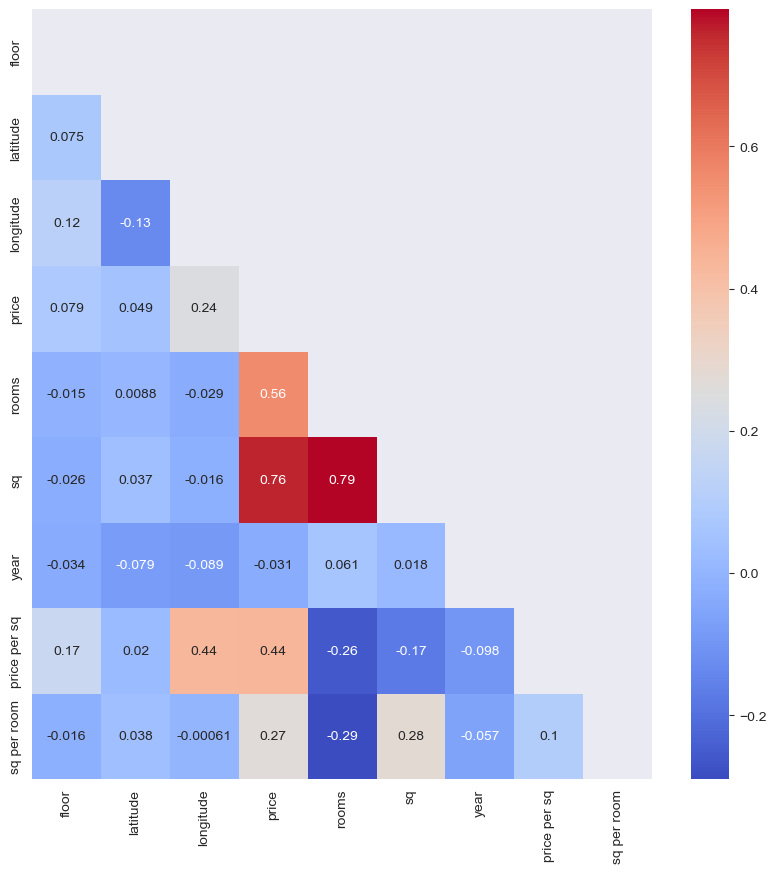

In [100]:
plt.figure(figsize=(10,10))
cor=ndc.corr()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor,mask=mask, annot = True, cmap=plt.cm.coolwarm)
plt.show()

### Scikit-learn model


In [101]:
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import  SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline

In [102]:
X_cat = ndc[['city']]
X_num = ndc.drop(['city','latitude', 'longitude', 'price per sq', 'sq per room', 'price'], axis = 1)

X_cat = pd.get_dummies(X_cat)

X = pd.concat([X_num, X_cat], axis = 1)

y = ndc['price']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, test_size=0.3, random_state = 444)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [104]:
names = ['KernelRidge', 'Linear Regression', 'SGD Regressor', 'K-Nearest Neighbors', 'Decision Tree', 'XGB Regressor']
models = [KernelRidge(), LinearRegression(), SGDRegressor(), KNeighborsRegressor(), DecisionTreeRegressor(), XGBRegressor()]

results = pd.DataFrame(columns = ['RMSE'], index = names)
scores_RMSE=[]

for model in models:

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    scores_RMSE.append(score)


results['RMSE'] = scores_RMSE
results.sort_values(by = 'RMSE', ascending = True)

,RMSE
XGB Regressor,123722.898089
K-Nearest Neighbors,139400.145439
Decision Tree,147531.811856
Linear Regression,165146.808525
SGD Regressor,165622.614605
KernelRidge,611917.858779


Let's focus on XGB Regressor

In [105]:
pipeline = Pipeline([
    ('rs', RandomizedSearchCV(
        estimator=XGBRegressor(random_state=444),
        param_distributions={
            'n_estimators': [50, 100, 200, 500],
            'max_depth': [int(x) for x in np.linspace(10, 100, num=10)],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.5, 0.8, 1.0],
            'colsample_bytree': [0.5, 0.8, 1.0]
        },
        n_iter=100,
        cv=KFold(n_splits=5, shuffle=True, random_state=444),
        n_jobs=-1,
        verbose=2,
        scoring='neg_mean_squared_error'
    ))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best parameters found: ", pipeline.named_steps['rs'].best_params_)
print("Lowest RMSE found: ", np.sqrt(-pipeline.named_steps['rs'].best_score_))
print("Final MSE: ", mse)
print("Final MAE: ", mae)
print("Final R^2 score: ", r2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 90, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Lowest RMSE found:  118256.9920849215
Final MSE:  13052532866.922081
Final MAE:  65595.9943187563
Final R^2 score:  0.8385918743661761


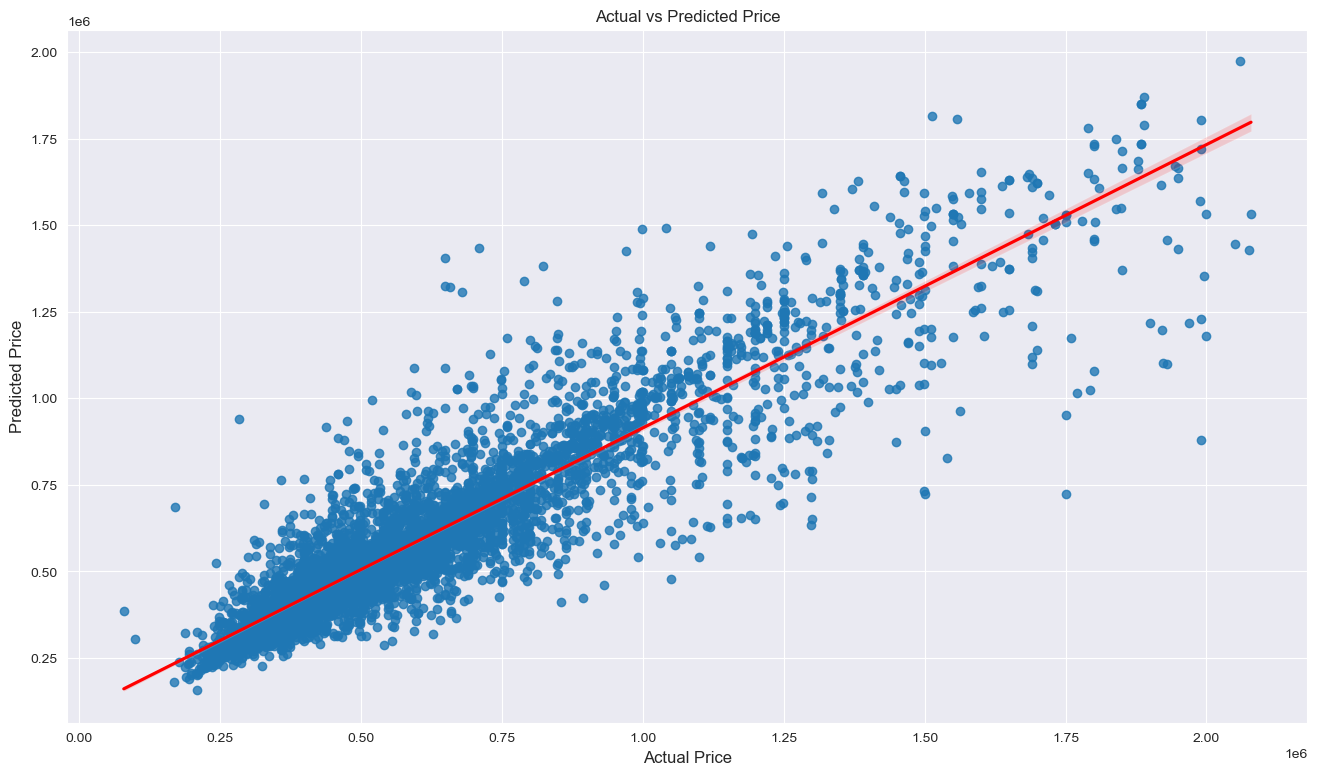

In [106]:
plt.figure(figsize=(16,9))
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"})
plt.title("Actual vs Predicted Price", fontsize = 12)
plt.xlabel("Actual Price", fontsize = 12)
plt.ylabel("Predicted Price", fontsize = 12)

plt.show()

We can also visualise feature importance.

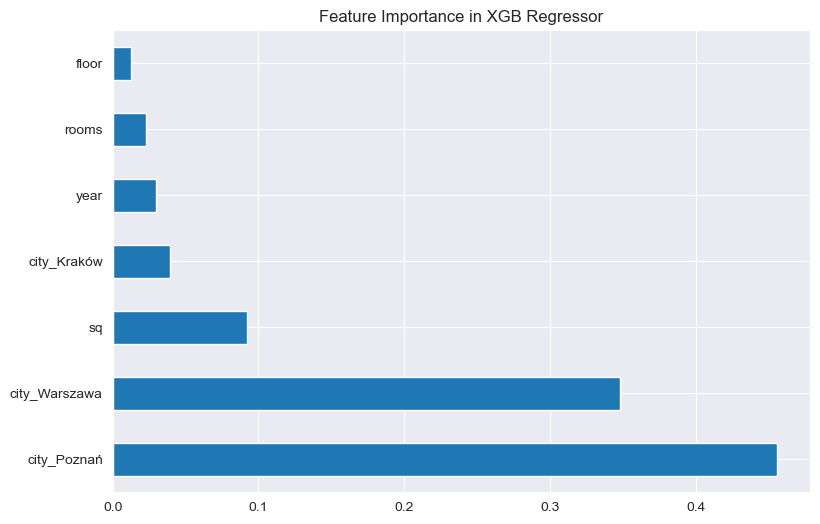

In [112]:
xgb_model = pipeline.named_steps['rs'].best_estimator_

importances_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns)

sorted_importances = importances_xgb.sort_values(ascending=False)

plt.figure(figsize=(9,6))
sorted_importances.plot(kind='barh')
plt.title('Feature Importance in XGB Regressor')
plt.show()